# DAMAGE DETECTION USING GPR

## DEPENDENCIES

In [2]:
# import libraries
import math

import numpy as np

import scipy
from scipy.io import loadmat  # for loading matlab files

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import GridSearchCV


## LOAD DATA

In [3]:
# load the results
RX = np.load('RX.npy')
RY = np.load('RY.npy')
RZ = np.load('RZ.npy')

In [4]:
# drop_list
drop_list = np.load('drop_list.npy')  

In [5]:
dim1 = RX.shape[0] # number of different strength drops
dim2 = RX.shape[1] # number of different samples
dim3 = RX.shape[2] # number of monitoring points

In [6]:
BASE_X_A = RX[0,:,0].squeeze()
BASE_X_B = RX[0,:,1].squeeze()
BASE_Y_A = RY[0,:,0].squeeze()
BASE_Y_B = RY[0,:,1].squeeze()
BASE_Z_A = RZ[0,:,0].squeeze()
BASE_Z_B = RZ[0,:,1].squeeze()


In [7]:
DETECT_X_A = RX[1:,:,0].squeeze()
DETECT_X_B = RX[1:,:,1].squeeze()
DETECT_Y_A = RY[1:,:,0].squeeze()
DETECT_Y_B = RY[1:,:,1].squeeze()
DETECT_Z_A = RZ[1:,:,0].squeeze()
DETECT_Z_B = RZ[1:,:,1].squeeze()

DETECT_X_A_AVG = np.mean(DETECT_X_A, axis=1) # model input for prediction
DETECT_X_B_AVG = np.mean(DETECT_X_B, axis=1) # ground truth for output prediction

DETECT_Y_A_AVG = np.mean(DETECT_Y_A, axis=1) # model input for prediction
DETECT_Y_B_AVG = np.mean(DETECT_Y_B, axis=1) # ground truth for output prediction

DETECT_Z_A_AVG = np.mean(DETECT_Z_A, axis=1) # model input for prediction
DETECT_Z_B_AVG = np.mean(DETECT_Z_B, axis=1) # ground truth for output prediction

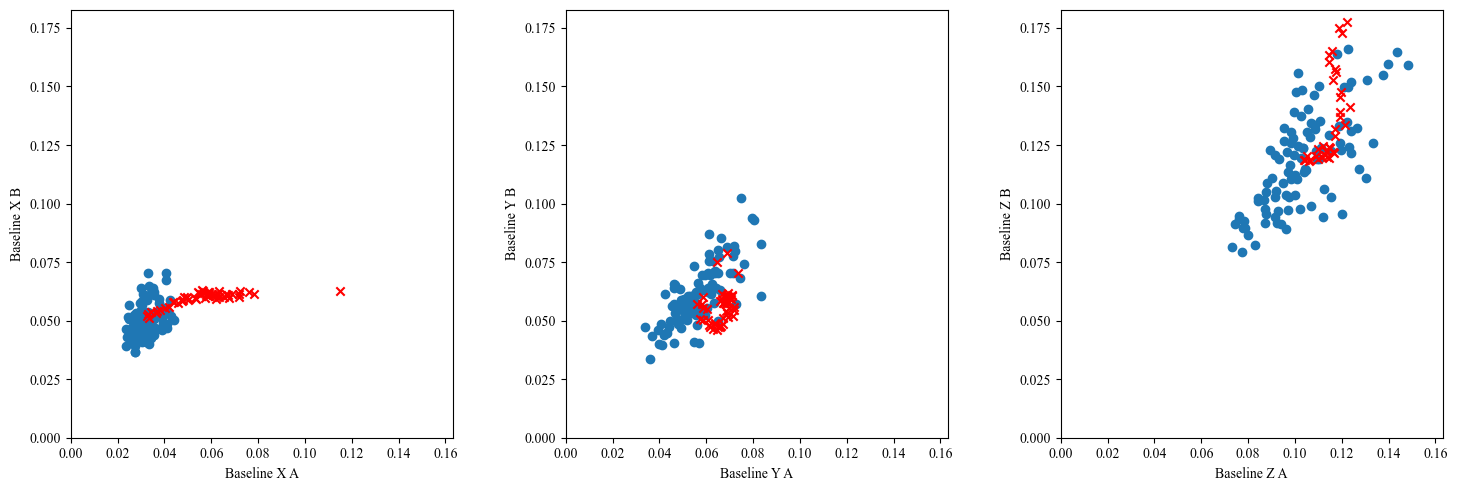

In [8]:
# plot the baseline points for X Y Z three directions, use subplot 1 by 3, unify the limits, 2D plot, A as the horizontal axis, B as the vertical axis

max_disp_A = np.max(np.concatenate((BASE_X_A, BASE_Y_A, BASE_Z_A)))
max_disp_B = np.max(np.concatenate((BASE_X_B, BASE_Y_B, BASE_Z_B)))
limit_A = 1.1*max_disp_A
limit_B = 1.1*max_disp_B


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Baseline X
ax[0].scatter(BASE_X_A, BASE_X_B)
ax[0].scatter(DETECT_X_A_AVG, DETECT_X_B_AVG, c='r', marker='x')
ax[0].set_xlabel('Baseline X A')
ax[0].set_ylabel('Baseline X B')
ax[0].set_xlim([0, limit_A])
ax[0].set_ylim([0, limit_B])
ax[0].set_aspect('equal', adjustable='box')  # Ensure equal scaling for x and y axes

# Baseline Y
ax[1].scatter(BASE_Y_A, BASE_Y_B)
ax[1].scatter(DETECT_Y_A_AVG, DETECT_Y_B_AVG, c='r', marker='x')
ax[1].set_xlabel('Baseline Y A')
ax[1].set_ylabel('Baseline Y B')
ax[1].set_xlim([0, limit_A])
ax[1].set_ylim([0, limit_B])
ax[1].set_aspect('equal', adjustable='box')  # Ensure equal scaling for x and y axes

# Baseline Z
ax[2].scatter(BASE_Z_A, BASE_Z_B)
ax[2].scatter(DETECT_Z_A_AVG, DETECT_Z_B_AVG, c='r', marker='x')
ax[2].set_xlabel('Baseline Z A')
ax[2].set_ylabel('Baseline Z B')
ax[2].set_xlim([0, limit_A])
ax[2].set_ylim([0, limit_B])
ax[2].set_aspect('equal', adjustable='box')  # Ensure equal scaling for x and y axes

plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()


In [9]:
# Check the data for prediction

limit_A = 0.3
limit_B = 1

for i in range(DETECT_X_A.shape[0]):
    X_A = DETECT_X_A[i]
    X_B = DETECT_X_B[i]
    
    Y_A = DETECT_Y_A[i]
    Y_B = DETECT_Y_B[i]
    
    Z_A = DETECT_Z_A[i]
    Z_B = DETECT_Z_B[i]
    
    
    
    # fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # # X
    # ax[0].scatter(X_A, X_B)
    # ax[0].scatter(DETECT_X_A_AVG[i], DETECT_X_B_AVG[i], c='r', marker='x', label='Average')
    # ax[0].set_xlabel('X A')
    # ax[0].set_ylabel('X B')
    # ax[0].set_xlim([0, limit_A])
    # ax[0].set_ylim([0, limit_B])
    
    # # Y
    # ax[1].scatter(Y_A, Y_B)
    # ax[1].scatter(DETECT_Y_A_AVG[i], DETECT_Y_B_AVG[i], c='r', marker='x', label='Average')
    # ax[1].set_xlabel('Y A')
    # ax[1].set_ylabel('Y B')
    # ax[1].set_xlim([0, limit_A])
    # ax[1].set_ylim([0, limit_B])
    
    # # Z
    # ax[2].scatter(Z_A, Z_B)
    # ax[2].scatter(DETECT_Z_A_AVG[i], DETECT_Z_B_AVG[i], c='r', marker='x', label='Average')
    # ax[2].set_xlabel('Z A')
    # ax[2].set_ylabel('Z B')
    # ax[2].set_xlim([0, limit_A])
    # ax[2].set_ylim([0, limit_B])
    
    # plt.tight_layout()  # Adjust layout to prevent label overlap
    # plt.show()

## BASELINE MODEL CONSTRUCTION

In [10]:
# alpha_X = 1 # noise level
# alpha_Y = 1 # noise level
# alpha_Z = 1 # noise level

# alpha_X = 0.3 # noise level
# alpha_Y = 5 # noise level
# alpha_Z = 7.5 # noise level

alpha_X = 1.5 # noise level
alpha_Y = 5 # noise level
alpha_Z = 5 # noise level

In [11]:
# define the kernel
# kernel = ConstantKernel(sigmaM0) * RBF(sigmaF0)
# kernel_X = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=0.05, length_scale_bounds=(1e-2, 1e2))
# kernel_Y = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
# kernel_Z = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# kernel_X = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1)
# kernel_Y = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1)
# kernel_Z = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=1)

kernel_X = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=0.1)
kernel_Y = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=0.01)
kernel_Z = ConstantKernel(1.0, (1e-2, 1e2)) * RBF(length_scale=0.01)

# define the model using the defined kernel
gprMdl_X = GaussianProcessRegressor(kernel = kernel_X, alpha = alpha_X, normalize_y = True)
gprMdl_Y = GaussianProcessRegressor(kernel = kernel_Y, alpha = alpha_Y, normalize_y = True)
gprMdl_Z = GaussianProcessRegressor(kernel = kernel_Z, alpha = alpha_Z, normalize_y = True)

# Fit the model with the training data
gprMdl_X.fit(BASE_X_A.reshape(-1,1), BASE_X_B.reshape(-1,1))
gprMdl_Y.fit(BASE_Y_A.reshape(-1,1), BASE_Y_B.reshape(-1,1))
gprMdl_Z.fit(BASE_Z_A.reshape(-1,1), BASE_Z_B.reshape(-1,1))


GaussianProcessRegressor(alpha=5, kernel=1**2 * RBF(length_scale=0.01),
                         normalize_y=True)

In [12]:
ub_A_X = 1.5*max(BASE_X_A)
ub_A_Y = 1.5*max(BASE_Y_A)
ub_A_Z = 1.5*max(BASE_Z_A)
ub_A = max([ub_A_X, ub_A_Y, ub_A_Z])

# regression
AA_X = np.linspace(0, ub_A_X, 100).reshape(-1,1)
AA_Y = np.linspace(0, ub_A_Y, 100).reshape(-1,1)
AA_Z = np.linspace(0, ub_A_Z, 100).reshape(-1,1)

BB_X, BB_X_std = gprMdl_X.predict(AA_X, return_std=True)
BB_Y, BB_Y_std = gprMdl_Y.predict(AA_Y, return_std=True)
BB_Z, BB_Z_std = gprMdl_Z.predict(AA_Z, return_std=True)

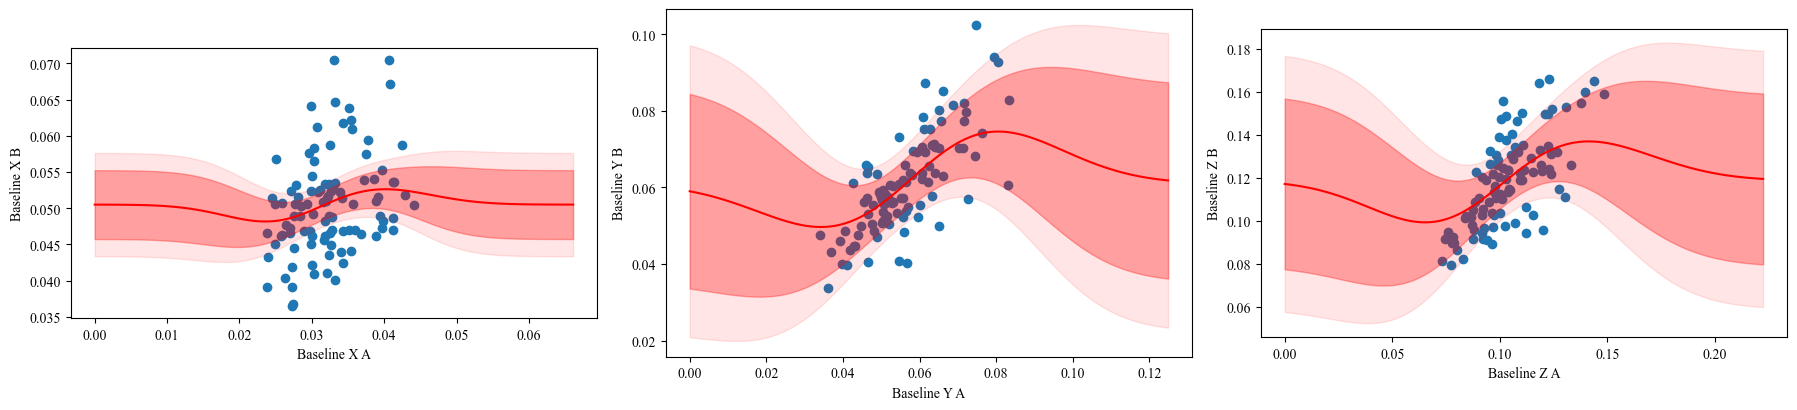

In [13]:
# plot the training data and the regression results
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

X_x_limit = 1.1*max(np.concatenate((BASE_X_A, DETECT_X_A_AVG)))
X_y_limit = 1.1*max(np.concatenate((BASE_X_B, DETECT_X_B_AVG)))

Y_x_limit = 1.1*max(np.concatenate((BASE_Y_A, DETECT_Y_A_AVG)))
Y_y_limit = 1.1*max(np.concatenate((BASE_Y_B, DETECT_Y_B_AVG)))

Z_x_limit = 1.1*max(np.concatenate((BASE_Z_A, DETECT_Z_A_AVG)))
Z_y_limit = 1.1*max(np.concatenate((BASE_Z_B, DETECT_Z_B_AVG)))

# Baseline X
ax[0].scatter(BASE_X_A, BASE_X_B)
ax[0].plot(AA_X, BB_X, c='r', label='Regression')
ax[0].fill_between(AA_X.squeeze(), (BB_X - 2*BB_X_std).squeeze(), (BB_X + 2*BB_X_std).squeeze(), color='r', alpha=0.3)
ax[0].fill_between(AA_X.squeeze(), (BB_X - 3*BB_X_std).squeeze(), (BB_X + 3*BB_X_std).squeeze(), color='r', alpha=0.1)
ax[0].set_xlabel('Baseline X A')
ax[0].set_ylabel('Baseline X B')
# ax[0].set_xlim([0, X_x_limit])
# ax[0].set_ylim([0, X_y_limit])
ax[0].set_aspect('equal', adjustable='box')  # Set equal aspect ratio

# Baseline Y
ax[1].scatter(BASE_Y_A, BASE_Y_B)
ax[1].plot(AA_Y, BB_Y, c='r', label='Regression')
ax[1].fill_between(AA_Y.squeeze(), (BB_Y - 2*BB_Y_std).squeeze(), (BB_Y + 2*BB_Y_std).squeeze(), color='r', alpha=0.3)
ax[1].fill_between(AA_Y.squeeze(), (BB_Y - 3*BB_Y_std).squeeze(), (BB_Y + 3*BB_Y_std).squeeze(), color='r', alpha=0.1)
ax[1].set_xlabel('Baseline Y A')
ax[1].set_ylabel('Baseline Y B')
# ax[1].set_xlim([0, Y_x_limit])
# ax[1].set_ylim([0, Y_y_limit])
ax[1].set_aspect('equal', adjustable='box')  # Set equal aspect ratio

# Baseline Z
ax[2].scatter(BASE_Z_A, BASE_Z_B)
ax[2].plot(AA_Z, BB_Z, c='r', label='Regression')
ax[2].fill_between(AA_Z.squeeze(), (BB_Z - 2*BB_Z_std).squeeze(), (BB_Z + 2*BB_Z_std).squeeze(), color='r', alpha=0.3)
ax[2].fill_between(AA_Z.squeeze(), (BB_Z - 3*BB_Z_std).squeeze(), (BB_Z + 3*BB_Z_std).squeeze(), color='r', alpha=0.1)
ax[2].set_xlabel('Baseline Z A')
ax[2].set_ylabel('Baseline Z B')
# ax[2].set_xlim([0, Z_x_limit])
# ax[2].set_ylim([0, Z_y_limit])
ax[2].set_aspect('equal', adjustable='box')  # Set equal aspect ratio

plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()





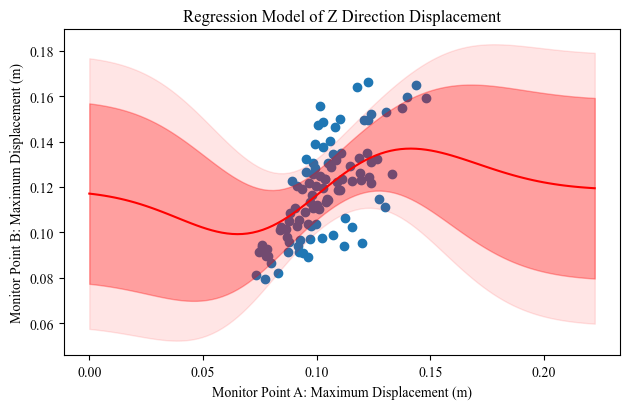

In [14]:
# plot Z direction

# plot the training data and the regression results
fig = plt.figure()
plt.scatter(BASE_Z_A, BASE_Z_B)
plt.plot(AA_Z, BB_Z, c='r', label='Regression')
plt.fill_between(AA_Z.squeeze(), (BB_Z - 2*BB_Z_std).squeeze(), (BB_Z + 2*BB_Z_std).squeeze(), color='r', alpha=0.3)
plt.fill_between(AA_Z.squeeze(), (BB_Z - 3*BB_Z_std).squeeze(), (BB_Z + 3*BB_Z_std).squeeze(), color='r', alpha=0.1)
plt.xlabel('Monitor Point A: Maximum Displacement (m)')
plt.ylabel('Monitor Point B: Maximum Displacement (m)')
# plt.xlim([0, Z_x_limit])
# plt.ylim([0, Z_y_limit])
plt.title('Regression Model of Z Direction Displacement')
plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio
plt.tight_layout()  # Adjust layout to prevent label overlap

#save the picture
plt.savefig('GPR_Model.png', dpi=300)
plt.show()



## DAMAGE DETECTION & SENSITIVITY ANALYSIS

### PREDICTION

In [15]:
# X
X_B_pred, X_B_pred_std = gprMdl_X.predict(DETECT_X_A_AVG.reshape(-1,1), return_std=True)

In [16]:
# Y
Y_B_pred, Y_B_pred_std = gprMdl_Y.predict(DETECT_Y_A_AVG.reshape(-1,1), return_std=True)

In [17]:
# Z
Z_B_pred, Z_B_pred_std = gprMdl_Z.predict(DETECT_Z_A_AVG.reshape(-1,1), return_std=True)

plot the ground truth and the prediction

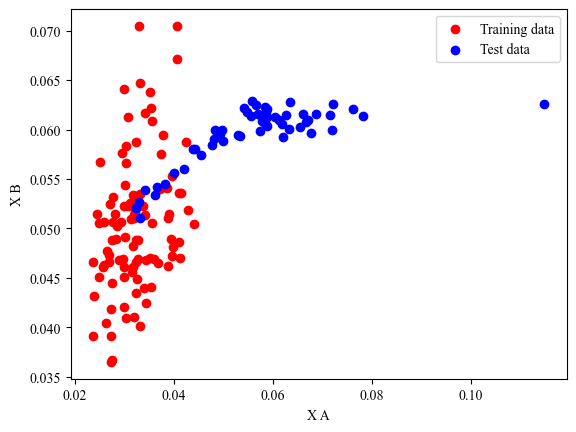

In [18]:
# X
# plot the training dataset, the prediction and the ground truth

fig = plt.figure()
plt.scatter(BASE_X_A, BASE_X_B, c='r', label='Training data')
# plt.scatter(BASE_X_A, BASE_X_B_PRED, c='g', label='Regression')
plt.scatter(DETECT_X_A_AVG, DETECT_X_B_AVG, c='b', label='Test data')
# plt.plot(DETECT_X_A_AVG, X_B_pred, c='g', label='Prediction')
plt.xlabel('X A')
plt.ylabel('X B')
plt.legend()
plt.show()

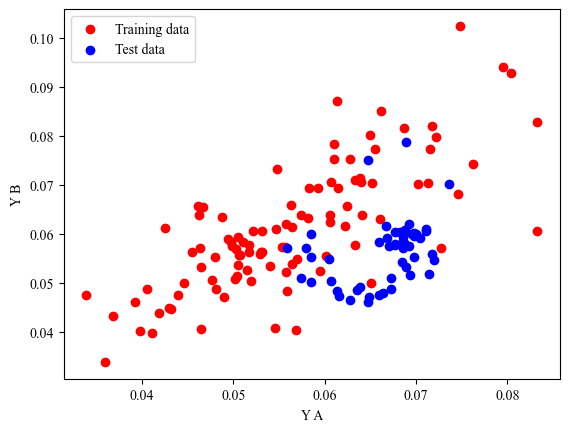

In [19]:
# Y
# plot the training dataset, the prediction and the ground truth

fig = plt.figure()
plt.scatter(BASE_Y_A, BASE_Y_B, c='r', label='Training data')
# plt.scatter(BASE_Y_A, BASE_Y_B_PRED, c='g', label='Regression')
plt.scatter(DETECT_Y_A_AVG, DETECT_Y_B_AVG, c='b', label='Test data')
# plt.plot(DETECT_Y_A_AVG, Y_B_pred, c='g', label='Prediction')
plt.xlabel('Y A')
plt.ylabel('Y B')
plt.legend()
plt.show()




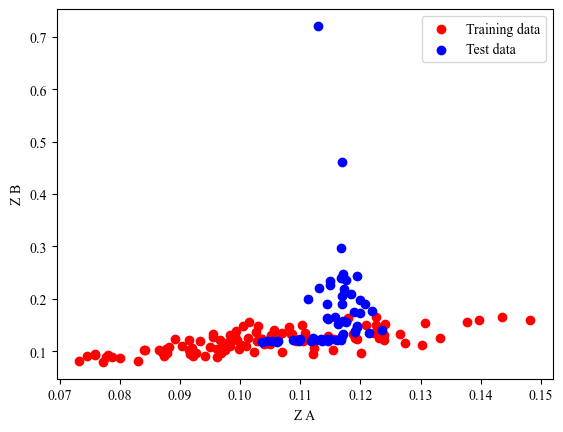

In [20]:
# Z
# plot the training dataset, the prediction and the ground truth

fig = plt.figure()
plt.scatter(BASE_Z_A, BASE_Z_B, c='r', label='Training data')
# plt.scatter(BASE_Z_A, BASE_Z_B_PRED, c='g', label='Regression')
plt.scatter(DETECT_Z_A_AVG, DETECT_Z_B_AVG, c='b', label='Test data')
# plt.plot(DETECT_Z_A_AVG, Z_B_pred, c='g', label='Prediction')
plt.xlabel('Z A')
plt.ylabel('Z B')
plt.legend()
plt.show()


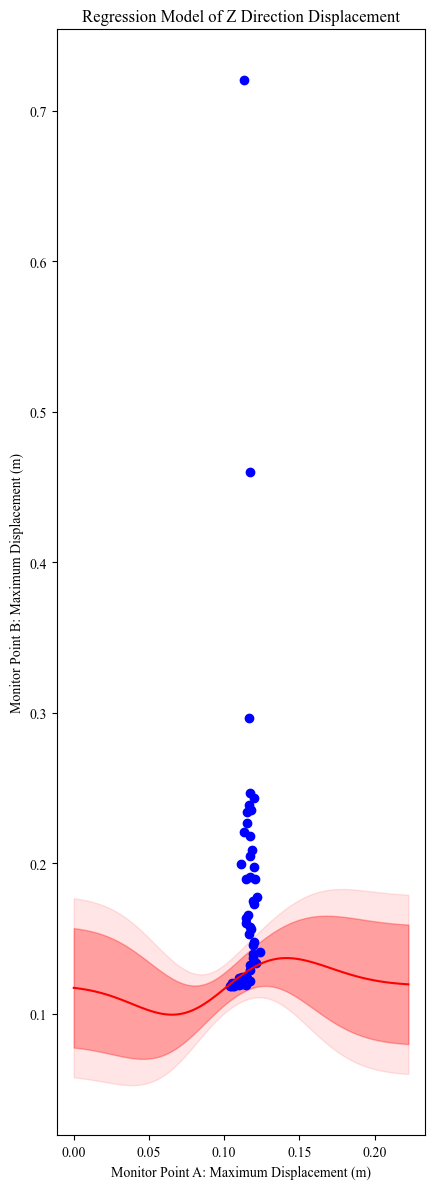

In [24]:
# plot Z direction

# plot the training data and the regression results
fig = plt.figure(figsize=(12, 12))
# plt.scatter(BASE_Z_A, BASE_Z_B)
plt.plot(AA_Z, BB_Z, c='r', label='Regression')
plt.fill_between(AA_Z.squeeze(), (BB_Z - 2*BB_Z_std).squeeze(), (BB_Z + 2*BB_Z_std).squeeze(), color='r', alpha=0.3)
plt.fill_between(AA_Z.squeeze(), (BB_Z - 3*BB_Z_std).squeeze(), (BB_Z + 3*BB_Z_std).squeeze(), color='r', alpha=0.1)
plt.scatter(DETECT_Z_A_AVG, DETECT_Z_B_AVG, c='b', label='Test data')
plt.xlabel('Monitor Point A: Maximum Displacement (m)')
plt.ylabel('Monitor Point B: Maximum Displacement (m)')
# plt.xlim([0, Z_x_limit])
# plt.ylim([0, Z_y_limit])
plt.title('Regression Model of Z Direction Displacement')
plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio
plt.tight_layout()  # Adjust layout to prevent label overlap

plt.show()